In [1]:
%%capture

import os
import torch
import tiktoken
import numpy as np
import pandas as pd
from glob import glob
import torch.nn as nn
from IPython.display import display
from datasets import Dataset as D
from torch.nn import functional as F, Embedding
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import GPT2Model, GPT2TokenizerFast, GPT2ForSequenceClassification

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
%matplotlib inline

2025-09-20 15:58:15.976970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758383896.137002      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758383896.192325      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class Config:
    device = "cuda:0"
    n_vocab = 50257
    d_model = 768
    max_length = 1024
    stride = 1024
    qkv_bias = True
    embedding_dropout = 0
    num_head = 12
    multihead_attention_dropout = 0
    num_of_stacked_transformer_blocks = 12

In [3]:
text_path = glob("/kaggle/input/text-data"+"/**.txt")[0]

with open(text_path, "r") as text_file:
    text_file_read = text_file.read()

In [4]:
tokenizer = tiktoken.get_encoding(encoding_name="gpt2")

In [5]:
class GPTDataset(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.X_out, self.y_out = [], []
        self.token_ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        assert len(self.token_ids)>max_length, f"Length of Token IDs {len(self.token_ids)} not greater than Max length {max_length}"

        for idx in range(0, len(self.token_ids)-max_length, stride):
            X, y = self.token_ids[idx:idx+max_length], self.token_ids[idx+1:idx+max_length+1]
            self.X_out.append(X)
            self.y_out.append(y)
        
    def __len__(self):
        return len(self.X_out)

    def __getitem__(self, idx):
        return torch.tensor(self.X_out[idx]), torch.tensor(self.y_out[idx])

def CreateDataLoader(data, tokenizer, cfg, batch_size, shuffle, drop_last, num_workers):
    dataset = GPTDataset(text=data, tokenizer=tokenizer, max_length=cfg.max_length, stride=cfg.stride)
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    return data_loader

In [6]:
train_size = .8
total_tokens = len(text_file_read)
train_ratio = int(train_size * total_tokens)
train_text = text_file_read[:train_ratio]
val_text = text_file_read[train_ratio:]

print("Train Length:", len(train_text), ", Val Length:", len(val_text))

Train Length: 16383 , Val Length: 4096


In [7]:
train_dl = CreateDataLoader(train_text, tokenizer, Config, 2, True, True, os.cpu_count())
val_dl = CreateDataLoader(val_text, tokenizer, Config, 2, False, False, os.cpu_count())

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, cfg):
        super(MultiHeadAttention, self).__init__()
        self.cfg = cfg
        assert cfg.d_model % cfg.num_head == 0, "cfg.d_model % cfg.num_head != 0"
        self.d_k = cfg.d_model // cfg.num_head
        # Attentions Projections
        self.W_q = nn.Linear(cfg.d_model, cfg.d_model, bias=cfg.qkv_bias)
        self.W_k = nn.Linear(cfg.d_model, cfg.d_model, bias=cfg.qkv_bias)
        self.W_v = nn.Linear(cfg.d_model, cfg.d_model, bias=cfg.qkv_bias)
        self.W_o = nn.Linear(cfg.d_model, cfg.d_model, bias=cfg.qkv_bias)
        # Dropout
        self.dropout = nn.Dropout(p=cfg.multihead_attention_dropout)

    def forward(self, x):
        batch_size, seq, d_model = x.size()
        q = self.W_q(x).view(batch_size, seq, self.cfg.num_head, self.d_k).transpose(1, 2)
        k = self.W_k(x).view(batch_size, seq, self.cfg.num_head, self.d_k).transpose(1, 2)
        v = self.W_v(x).view(batch_size, seq, self.cfg.num_head, self.d_k).transpose(1, 2)

        mask = torch.tril(torch.ones(seq, seq, device=x.device)).unsqueeze(0).unsqueeze(0) # (1, 1, seq, seq)
        attention_score = q @ k.transpose(-2, -1) / torch.sqrt(torch.tensor(self.d_k))
        attention = self.dropout(F.softmax(attention_score.masked_fill(mask==0, -torch.inf), dim=-1)) @ v # dropout(softmax(attention score  + mask)) @ v, dim=(batch_size, num_head, seq_len, d_k)
        output = attention.transpose(1, 2).contiguous().view(batch_size, seq, d_model) # (batch_size, seq, d_model)
        return self.W_o(output) # (batch_size, seq, d_model)

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * (x**3)))
        )

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super(FeedForward, self).__init__()
        self.cfg = cfg
        self.ff = nn.Sequential(
            nn.Linear(self.cfg.d_model, 4*self.cfg.d_model),
            GELU(),
            nn.Linear(4*self.cfg.d_model, self.cfg.d_model)
        )

    def forward(self, x):
        return self.ff(x)

class LayerNormalization(nn.Module):
    def __init__(self, cfg):
        super(LayerNormalization, self).__init__()
        self.eps = 1e-5
        self.Weight = nn.Parameter(torch.ones(cfg.d_model))
        self.bias = nn.Parameter(torch.zeros(cfg.d_model))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)
        return self.Weight * (x - mean) / torch.sqrt(variance+self.eps) + self.bias

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super(TransformerBlock, self).__init__()
        self.multihead_attention = MultiHeadAttention(cfg)
        self.layer_norm_1 = LayerNormalization(cfg)
        self.layer_norm_2 = LayerNormalization(cfg)
        self.dropout = nn.Dropout(p=cfg.multihead_attention_dropout)
        self.feedforward = FeedForward(cfg)

    def forward(self, x):
        shortcut = x
        x = self.layer_norm_1(x)
        x = self.multihead_attention(x)
        x = self.dropout(x)
        x = x + shortcut

        shortcut = x
        x = self.layer_norm_2(x)
        x = self.feedforward(x)
        x = self.dropout(x)
        x = x + shortcut
        return x # (batch_size, seq, d_model)

In [9]:
class GptModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        
        # Embeddings
        self.wrd_embeddings = nn.Embedding(cfg.n_vocab, cfg.d_model)
        self.pos_embeddings = nn.Embedding(cfg.max_length, cfg.d_model)
        self.embedding_dropout = nn.Dropout(p=cfg.embedding_dropout)

        # Stacked Multihead Attention
        # nn.Sequential([Block1, Block2, Block3])  # ❌ wrong thats why the * so that it will unpack the list into nn.Sequential(Block1, Block2, Block3)
        self.stack_mha = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg.num_of_stacked_transformer_blocks)])

        # Final layer norm
        self.final_layer_norm = LayerNormalization(cfg)

        # Output layer
        self.output_layer = nn.Linear(cfg.d_model, cfg.n_vocab)

    def forward(self, x):
        batch, seq = x.shape
        wrd_embed = self.wrd_embeddings(x) # (batch_size, seq, d_model)
        positions = torch.arange(seq, device=x.device).unsqueeze(0).expand(batch, -1) # (seq,) -> (1, seq) -> (batch, seq)
        pos_embed = self.pos_embeddings(positions) # (batch_size, seq, d_model)
        xout = self.embedding_dropout(wrd_embed + pos_embed)
        xout = self.stack_mha(xout) # (batch_size, seq, d_model)
        xout = self.final_layer_norm(xout) # (batch_size, seq, d_model)
        return self.output_layer(xout) # (batch_size, seq, n_vocabs)

In [10]:
gpt_model = GptModel(cfg=Config)

gpt_model

GptModel(
  (wrd_embeddings): Embedding(50257, 768)
  (pos_embeddings): Embedding(1024, 768)
  (embedding_dropout): Dropout(p=0, inplace=False)
  (stack_mha): Sequential(
    (0): TransformerBlock(
      (multihead_attention): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (W_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (layer_norm_1): LayerNormalization()
      (layer_norm_2): LayerNormalization()
      (dropout): Dropout(p=0, inplace=False)
      (feedforward): FeedForward(
        (ff): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (multihead_attenti

In [11]:
def GenerateText(model, token_ids, max_new_tokens=50, context_size=50, tokenizer=None, top_k=50, temperature=1.0):
    for _ in range(max_new_tokens):
        tkn_ids = token_ids[:, -context_size:]
        with torch.no_grad():
            logits = model(tkn_ids)  # (batch_size, seq, vocab_size)

        # Temperature scaling
        logits = logits[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)
        
        # Top-k sampling
        topk_probs, topk_indices = torch.topk(probs, top_k)
        topk_probs = topk_probs / topk_probs.sum(dim=-1, keepdim=True)
        next_token = topk_indices.gather(-1, torch.multinomial(topk_probs, num_samples=1))
        token_ids = torch.cat((token_ids, next_token), dim=1)
    
    return tokenizer.decode(token_ids[0].tolist())

In [12]:
input_txt = "I HAD always thought Jack Gisburn rather"
tkn_id = torch.tensor(tokenizer.encode(input_txt)).unsqueeze(0).to("cuda:0")

In [13]:
model_output = GenerateText(model=gpt_model.to("cuda:0"), token_ids=tkn_id, max_new_tokens=50, context_size=50, tokenizer=tokenizer)

model_output

'I HAD always thought Jack Gisburn rather up finest squared Funny pretext newfound sharkDriverraseilloregnancyowners Photography Romaniannder respects FI redundancy meats whilstchecksswerHy unnatural divorced sterilepayers(), Perezannah volatilityREFincreasing CentOSvs stargex date suppressingXTönernaut veter Iterl acquisitions ba CaucasianORTS Strip'

In [14]:
class Trainer:
    def __init__(self, model, train_dl, val_dl, optimizer, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device
        self.train_dl = train_dl
        self.val_dl = val_dl

    def train(self, train_dl):
        total_loss = 0
        self.model.train()
        for x, y in train_dl:
            self.optimizer.zero_grad()
            x, y = x.to(self.device), y.to(self.device) # y-shape: (batch_size, seq)
            logits = self.model(x) # (batch_size, seq_len, n_vocabs)
            loss = F.cross_entropy(logits.flatten(0, 1), y.flatten()) #logits.flatten(0, 1) -> (batch_size*seq_len, n_vocabs), y.flatten() -> (batch_size*seq_len,)
            loss.backward()
            self.optimizer.step()
            total_loss+=loss.item()
        return total_loss

    def eval(self, val_dl):
        total_loss = 0
        self.model.eval()
        for x, y in val_dl:
            with torch.no_grad():
                x, y = x.to(self.device), y.to(self.device)
                logits = self.model(x)
                loss = F.cross_entropy(logits.flatten(0, 1), y.flatten())
                total_loss+=loss.item()
        return total_loss

    def fit(self, n_epochs):
        display_models_output = 5
        for epoch in range(n_epochs):
            train_loss = self.train(self.train_dl)
            eval_loss = self.eval(self.val_dl)
    
            print(f"Epoch {epoch+1}/{n_epochs} -- Train loss: {train_loss:.4f} -- Val loss: {eval_loss:.4f}")
    
            if (epoch + 1) % display_models_output == 0:
                input_txt = "I HAD always thought Jack Gisburn rather"
                tkn_id = torch.tensor(tokenizer.encode(input_txt)).unsqueeze(0).to(self.device)
                output = GenerateText(
                    model=self.model,
                    token_ids=tkn_id,
                    max_new_tokens=30,
                    context_size=30,
                    tokenizer=tokenizer
                )
                print(output)

In [15]:
optimizer = torch.optim.AdamW(params=gpt_model.parameters(), lr=4e-5, weight_decay=.1)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [16]:
trainer = Trainer(model=gpt_model, train_dl=train_dl, val_dl=val_dl, optimizer=optimizer, device=device)

In [17]:
trainer.fit(n_epochs=100)

Epoch 1/100 -- Train loss: 21.8196 -- Val loss: 10.6089
Epoch 2/100 -- Train loss: 20.7487 -- Val loss: 10.2254
Epoch 3/100 -- Train loss: 19.7970 -- Val loss: 9.9052
Epoch 4/100 -- Train loss: 19.0993 -- Val loss: 9.6700
Epoch 5/100 -- Train loss: 18.6152 -- Val loss: 9.5029
I HAD always thought Jack Gisburn rather the the the lact.
 Smartstocks, the of..,. the.
". Eaton sponsored the840
eking, the,, the
Epoch 6/100 -- Train loss: 18.2498 -- Val loss: 9.3703
Epoch 7/100 -- Train loss: 17.9496 -- Val loss: 9.2641
Epoch 8/100 -- Train loss: 17.6783 -- Val loss: 9.1667
Epoch 9/100 -- Train loss: 17.4138 -- Val loss: 9.0775
Epoch 10/100 -- Train loss: 17.1506 -- Val loss: 8.9885
I HAD always thought Jack Gisburn rather the.








 FR protestors.














 the
Epoch 11/100 -- Train loss: 16.8786 -- Val loss: 8.9050
Epoch 12/100 -- Train loss: 16.5959 -- Val loss: 8.8262
Epoch 13/100 -- Train loss: 16.3071 -- Val loss: 8.7524
Epoch 14/100 -- Train loss: 16.0115 -- Val loss: 8.6873
Ep

#### Weight transfer

In [18]:
def CheckShapeMatch(pytorch_model, transformer_model):
    assert pytorch_model.shape == transformer_model.shape, f"Shape Mismatch {pytorch_model.shape} != {transformer_model.shape}"
    return nn.Parameter(transformer_model.clone().detach())

In [19]:
def TransferWeights(pytorch_model, transformer_model, n_stack=12):
    pytorch_model_weights = pytorch_model.state_dict()
    transformer_model_weights = transformer_model.state_dict()

    # Embeddings
    pytorch_model.wrd_embeddings.weight = CheckShapeMatch(
        pytorch_model_weights["wrd_embeddings.weight"], transformer_model_weights["wte.weight"]
    )
    pytorch_model.pos_embeddings.weight = CheckShapeMatch(
        pytorch_model_weights["pos_embeddings.weight"], transformer_model_weights["wpe.weight"]
    )

    for i in range(n_stack):
        """
        In PyTorch, nn.Linear(in_features, out_features) has a weight of shape:
            (out_features,in_features)
        But in many Transformer checkpoints (e.g., Hugging Face GPT), the saved weights for linear layers are stored as:
            (in_features, out_features)
        """
        # Split QKV from Hugging Face transformer
        q, k, v = np.split(transformer_model_weights[f"h.{i}.attn.c_attn.weight"], 3, -1)

        pytorch_model.stack_mha[i].multihead_attention.W_q.weight = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.multihead_attention.W_q.weight"], q.T
        )
        pytorch_model.stack_mha[i].multihead_attention.W_k.weight = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.multihead_attention.W_k.weight"], k.T
        )
        pytorch_model.stack_mha[i].multihead_attention.W_v.weight = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.multihead_attention.W_v.weight"], v.T
        )

        # Split QKV biases
        q, k, v = np.split(transformer_model_weights[f"h.{i}.attn.c_attn.bias"], 3, -1)
        pytorch_model.stack_mha[i].multihead_attention.W_q.bias = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.multihead_attention.W_q.bias"], q
        )
        pytorch_model.stack_mha[i].multihead_attention.W_k.bias = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.multihead_attention.W_k.bias"], k
        )
        pytorch_model.stack_mha[i].multihead_attention.W_v.bias = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.multihead_attention.W_v.bias"], v
        )

        # Attention output projection
        pytorch_model.stack_mha[i].multihead_attention.W_o.weight = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.multihead_attention.W_o.weight"], transformer_model_weights[f"h.{i}.attn.c_proj.weight"].T
        )
        pytorch_model.stack_mha[i].multihead_attention.W_o.bias = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.multihead_attention.W_o.bias"], transformer_model_weights[f"h.{i}.attn.c_proj.bias"]
        )

        # LayerNorms
        pytorch_model.stack_mha[i].layer_norm_1.Weight = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.layer_norm_1.Weight"], transformer_model_weights[f"h.{i}.ln_1.weight"]
        )
        pytorch_model.stack_mha[i].layer_norm_1.bias = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.layer_norm_1.bias"], transformer_model_weights[f"h.{i}.ln_1.bias"]
        )
        pytorch_model.stack_mha[i].layer_norm_2.Weight = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.layer_norm_2.Weight"], transformer_model_weights[f"h.{i}.ln_2.weight"]
        )
        pytorch_model.stack_mha[i].layer_norm_2.bias = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.layer_norm_2.bias"], transformer_model_weights[f"h.{i}.ln_2.bias"]
        )

        # Feedforward / MLP layers
        pytorch_model.stack_mha[i].feedforward.ff[0].weight = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.feedforward.ff.0.weight"], transformer_model_weights[f"h.{i}.mlp.c_fc.weight"].T
        )
        pytorch_model.stack_mha[i].feedforward.ff[0].bias = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.feedforward.ff.0.bias"], transformer_model_weights[f"h.{i}.mlp.c_fc.bias"]
        )
        pytorch_model.stack_mha[i].feedforward.ff[2].weight = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.feedforward.ff.2.weight"], transformer_model_weights[f"h.{i}.mlp.c_proj.weight"].T
        )
        pytorch_model.stack_mha[i].feedforward.ff[2].bias = CheckShapeMatch(
            pytorch_model_weights[f"stack_mha.{i}.feedforward.ff.2.bias"], transformer_model_weights[f"h.{i}.mlp.c_proj.bias"]
        )

    # Final LayerNorm
    pytorch_model.final_layer_norm.Weight = CheckShapeMatch(
        pytorch_model_weights["final_layer_norm.Weight"], transformer_model_weights["ln_f.weight"]
    )
    pytorch_model.final_layer_norm.bias = CheckShapeMatch(
        pytorch_model_weights["final_layer_norm.bias"], transformer_model_weights["ln_f.bias"]
    )

    # Check if output matches token embedding
    pytorch_model.output_layer.weight = CheckShapeMatch(
            pytorch_model_weights["output_layer.weight"], transformer_model_weights["wte.weight"]
        )

In [20]:
transformer_gpt = GPT2Model.from_pretrained('gpt2')

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [21]:
gpt_model_init = GptModel(cfg=Config)
TransferWeights(gpt_model_init, transformer_gpt) 
input_txt = "I HAD always thought Jack Gisburn rather" 
tkn_id = torch.tensor(tokenizer.encode(input_txt)).unsqueeze(0).to("cuda:0")
model_output = GenerateText(model=gpt_model_init.to("cuda:0"), token_ids=tkn_id, max_new_tokens=50, context_size=50, tokenizer=tokenizer) 
model_output

'I HAD always thought Jack Gisburn rather looked like a guy who was a little too old for the role, so this is a bit of an oddity. Gisburn is a good role.\n\n\nA few minutes later he was standing in front of a table that looked less like'

#### Classification

In [22]:
%%capture

import os
import torch
import tiktoken
import numpy as np
import pandas as pd
from glob import glob
import torch.nn as nn
from datasets import Dataset as D
from IPython.display import display
from torch.nn import functional as F, Embedding
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import GPT2Model, GPT2TokenizerFast, GPT2ForSequenceClassification

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
%matplotlib inline

In [23]:
df = pd.read_csv("/kaggle/input/email-spam-detection-dataset-classification/spam.csv", encoding="latin-1")

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [24]:
df = df[["v2", "v1"]].rename({"v1":"y", "v2":"X"}, axis=1)

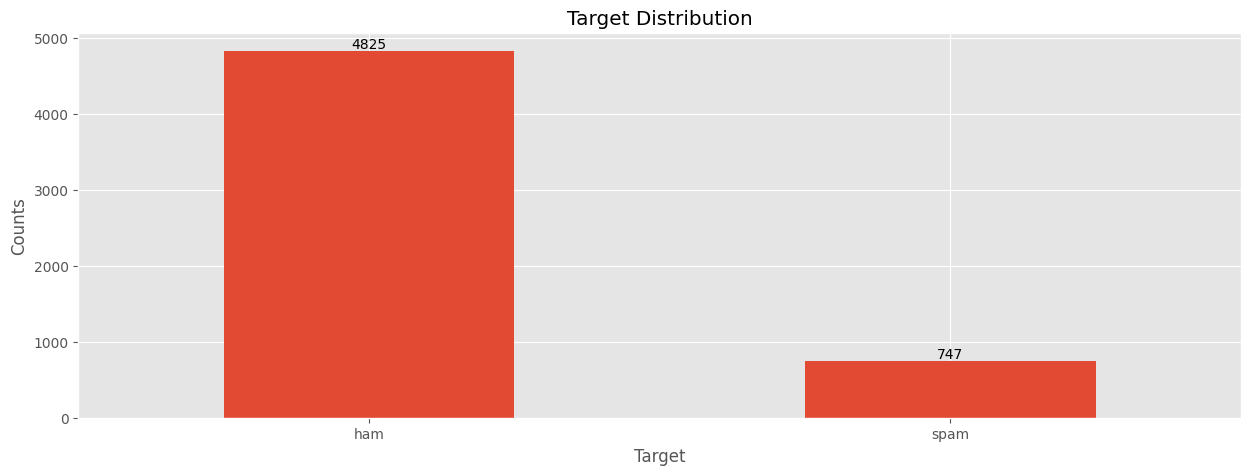

In [25]:
target_dist = df["y"].value_counts().plot(kind="bar",
                                          figsize=(15, 5),
                                          title="Target Distribution", 
                                          xlabel="Target", 
                                          ylabel="Counts")

for p in target_dist.patches:
    target_dist.text(p.get_x()+p.get_width()/2, 
                     p.get_height(),
                     p.get_height(), 
                     va="bottom", 
                     ha="center")
    target_dist.set_xticklabels(labels=target_dist.get_xticklabels(), rotation=0)
    
    
plt.show()

In [26]:
df["sentence_length"] = df["X"].str.len()
df["word_count"] = df["X"].apply(lambda x: len(x.split()))
df["mean_word_count"] = df["X"].apply(lambda x: np.mean([len(i) for i in x.split()]))

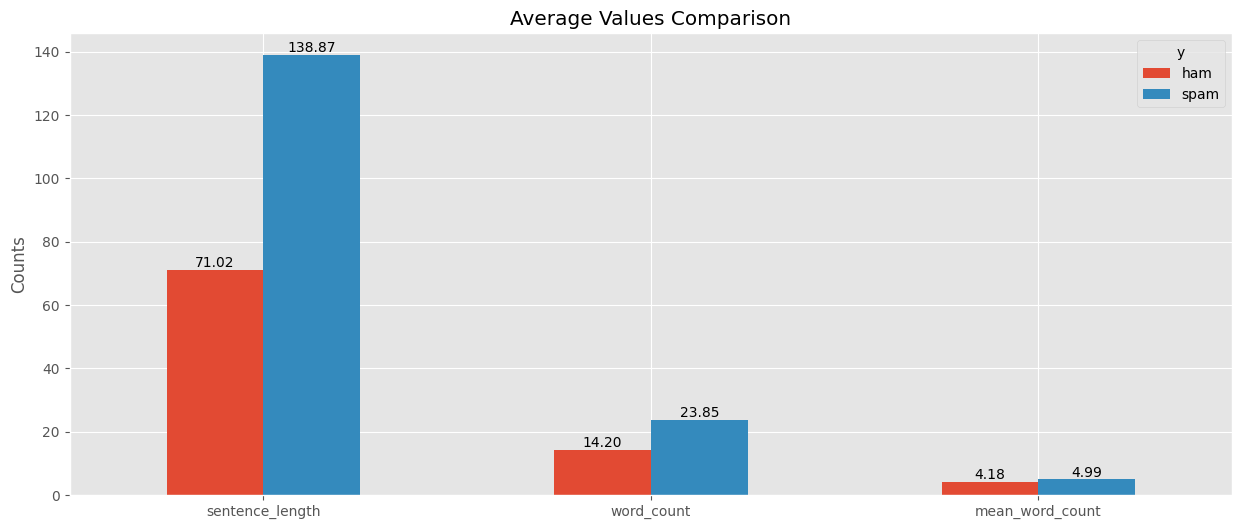

In [27]:
insight = df.groupby('y')[['sentence_length', 
                             'word_count',
                             'mean_word_count']].mean().T.plot(kind="bar",
                                                               figsize=(15, 6),
                                                               title="Average Values Comparison",
                                                               # xlabel="Features",
                                                               ylabel="Counts")

for p in insight.patches:
    insight.text(p.get_x()+p.get_width()/2, 
                 p.get_height(),
                 f"{p.get_height():.2f}", 
                 va="bottom", 
                 ha="center")
    insight.set_xticklabels(labels=insight.get_xticklabels(), rotation=0)
    
    
plt.show()

In [28]:
gpt_tokenizer_fast = GPT2TokenizerFast.from_pretrained("gpt2")
# set pad token to end of speech token
gpt_tokenizer_fast.pad_token = gpt_tokenizer_fast.eos_token

gpt_tokenizer_fast

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [29]:
gpt_model_with_attention = GPT2ForSequenceClassification.from_pretrained("gpt2",
                                                                         pad_token_id=gpt_tokenizer_fast.pad_token_id)

gpt_model_with_attention

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [30]:
for name, param in gpt_model_with_attention.named_parameters():
    param.require_grad = False

for name, param in gpt_model_with_attention.score.named_parameters():
    param.require_grad = True

In [31]:
df["is_spam"] = df["y"].map({"ham":1, "spam":0})

In [32]:
spam_dataset = D.from_pandas(df[["X", "is_spam"]])

spam_dataset

Dataset({
    features: ['X', 'is_spam'],
    num_rows: 5572
})

In [33]:
class ClassificationTrainer:
    def __init__(self, prep_dataset, model,tokenizer,
                 optimizer, batch_size=32, cv=5, 
                 shuffle=True, seed=2025, device="cuda:0"):
        self.prep_dataset = prep_dataset
        self.cv = cv
        self.optimizer = optimizer
        self.device = device
        self.model = model.to(device)
        self.seed = seed
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.df = prep_dataset.to_pandas()

    def train_dl(self, train_fold_dl, handle_gradient_explode=False):
        self.model.train()
        total_loss = 0
        total_accuracy = 0
        total_precision = 0
        
        for batch in train_fold_dl:
            self.optimizer.zero_grad()
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)
            
            output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            logits = output.logits
            loss = output.loss

            # get pred
            pred = torch.argmax(logits, dim=1)
            # update loss, accuracy
            total_loss += loss.item() / len(train_fold_dl)
            total_accuracy += accuracy_score(labels.cpu(), pred.cpu()) / len(train_fold_dl)
            total_precision += precision_score(labels.cpu(), pred.cpu()) / len(train_fold_dl)
            
            loss.backward()

            # Handle Gradient Explode
            if handle_gradient_explode:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
        return total_loss, total_accuracy, total_precision

    def eval_dl(self, train_fold_dl):
        self.model.eval()
        total_loss = 0
        total_accuracy = 0
        total_precision = 0

        with torch.no_grad():
            for batch in train_fold_dl:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)
                
                output = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    
                logits = output.logits
                loss = output.loss
    
                # get pred
                pred = torch.argmax(logits, dim=1)
                # update loss, accuracy
                total_loss += loss.item() / len(train_fold_dl)
                total_accuracy += accuracy_score(labels.cpu(), pred.cpu()) / len(train_fold_dl)
                total_precision += precision_score(labels.cpu(), pred.cpu()) / len(train_fold_dl)
            
        return total_loss, total_accuracy, total_precision

    def collate_fn(self, batch):
        """
            Custom collate function:
            - Takes a list of dataset examples (batch) as input
            - Tokenizes the raw text on-the-fly (so you don’t need to tokenize the whole dataset in advance)
            - Pads all sequences in the batch to the same length
            - Returns PyTorch tensors: input_ids, attention_mask, and labels
       """
        text_batch = [i["X"] for i in batch]
        label_batch = torch.tensor([i["is_spam"] for i in batch], dtype=torch.long)
        tokenized_text = self.tokenizer(text_batch, padding=True, return_tensors="pt")
        tokenized_text["labels"] = label_batch
        return tokenized_text
        
    def train(self, handle_gradient_explode=False):
        stkf = StratifiedKFold(n_splits=self.cv, 
                               shuffle=self.shuffle,
                               random_state=self.seed if self.cv else None)

        model_performance = {"fold":[], "train_accuracy":[],
                             "eval_accuracy":[], "train_loss":[],
                             "eval_loss":[], "train_precision":[],
                             "eval_precision":[]}
        
        for fold, (train_idx, val_idx) in enumerate(stkf.split(self.df["X"], self.df["is_spam"])):
            train_fold, val_fold = Subset(self.prep_dataset, train_idx), Subset(self.prep_dataset, val_idx)
            train_fold_dl = DataLoader(dataset=train_fold, 
                                       batch_size=self.batch_size, 
                                       shuffle=self.shuffle,
                                       collate_fn=self.collate_fn, # For batch preprocessing
                                       drop_last=True)
            val_fold_dl = DataLoader(dataset=val_fold, 
                                     batch_size=self.batch_size, 
                                     collate_fn=self.collate_fn, # For batch preprocessing
                                     shuffle=False, 
                                     drop_last=True)    

            train_loss, train_accuracy, train_precision = self.train_dl(train_fold_dl, handle_gradient_explode)
            eval_loss, eval_accuracy, eval_precision = self.eval_dl(train_fold_dl)

            model_performance["fold"].append(str(fold+1))
            model_performance["train_accuracy"].append(train_accuracy)
            model_performance["eval_accuracy"].append(eval_accuracy)
            model_performance["train_loss"].append(train_loss)
            model_performance["eval_loss"].append(eval_loss)
            model_performance["train_precision"].append(train_precision)
            model_performance["eval_precision"].append(eval_precision)

        model_performance = pd.DataFrame(model_performance)

        mean_performance = pd.DataFrame(model_performance.mean(numeric_only=True)).T
        mean_performance["fold"] = "mean"

        model_performance = pd.concat([model_performance[model_performance.columns], 
                                       mean_performance[model_performance.columns]], axis=0)

        model_performance.set_index("fold", inplace=True)
        
        display(model_performance)

        return model_performance

In [34]:
optimizer = torch.optim.AdamW(params=gpt_model_with_attention.parameters(), lr=4e-5, weight_decay=.1)
classification_trainer_1 = ClassificationTrainer(spam_dataset, gpt_model_with_attention, gpt_tokenizer_fast, optimizer)
classification_trainer_2 = ClassificationTrainer(spam_dataset, gpt_model_with_attention, gpt_tokenizer_fast, optimizer)

#### Without handling gradient Explode

In [35]:
class_model_performance_1 = classification_trainer_1.train()

,train_accuracy,eval_accuracy,train_loss,eval_loss,train_precision,eval_precision
fold,,,,,,
1,0.970099,0.995504,0.082175,0.021616,0.976273,0.997149
2,0.992581,0.997977,0.027422,0.007634,0.994184,0.998443
3,0.996403,0.999326,0.010093,0.003710,0.997124,0.999501
4,0.998201,1.000000,0.005140,0.000930,0.998175,1.000000
5,0.997977,0.991906,0.007160,0.021912,0.998959,1.000000
mean,0.991052,0.996942,0.026398,0.011160,0.992943,0.999019


In [36]:
def plot_training_metrics(df):
    df_plot = df[df.index != 'mean']
    
    folds = df_plot.index.astype(str)
    
    plt.figure(figsize=(16, 5))

    # --- Accuracy ---
    plt.subplot(1, 3, 1)
    plt.plot(folds, df_plot['train_accuracy'], marker='o', label='Train Accuracy')
    plt.plot(folds, df_plot['eval_accuracy'], marker='o', label='Eval Accuracy')
    plt.axhline(df.loc['mean', 'train_accuracy'], color='blue', linestyle='--', label='Mean Train Acc')
    plt.axhline(df.loc['mean', 'eval_accuracy'], color='orange', linestyle='--', label='Mean Eval Acc')
    plt.title('Accuracy per Fold')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.legend()
    
    # --- Loss ---
    plt.subplot(1, 3, 2)
    plt.plot(folds, df_plot['train_loss'], marker='o', label='Train Loss')
    plt.plot(folds, df_plot['eval_loss'], marker='o', label='Eval Loss')
    plt.axhline(df.loc['mean', 'train_loss'], color='blue', linestyle='--', label='Mean Train Loss')
    plt.axhline(df.loc['mean', 'eval_loss'], color='orange', linestyle='--', label='Mean Eval Loss')
    plt.title('Loss per Fold')
    plt.xlabel('Fold')
    plt.ylabel('Loss')
    plt.legend()
    
    # --- Precision ---
    plt.subplot(1, 3, 3)
    plt.plot(folds, df_plot['train_precision'], marker='o', label='Train Precision')
    plt.plot(folds, df_plot['eval_precision'], marker='o', label='Eval Precision')
    plt.axhline(df.loc['mean', 'train_precision'], color='blue', linestyle='--', label='Mean Train Precision')
    plt.axhline(df.loc['mean', 'eval_precision'], color='orange', linestyle='--', label='Mean Eval Precision')
    plt.title('Precision per Fold')
    plt.xlabel('Fold')
    plt.ylabel('Precision')
    plt.ylim(0, 1.05)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

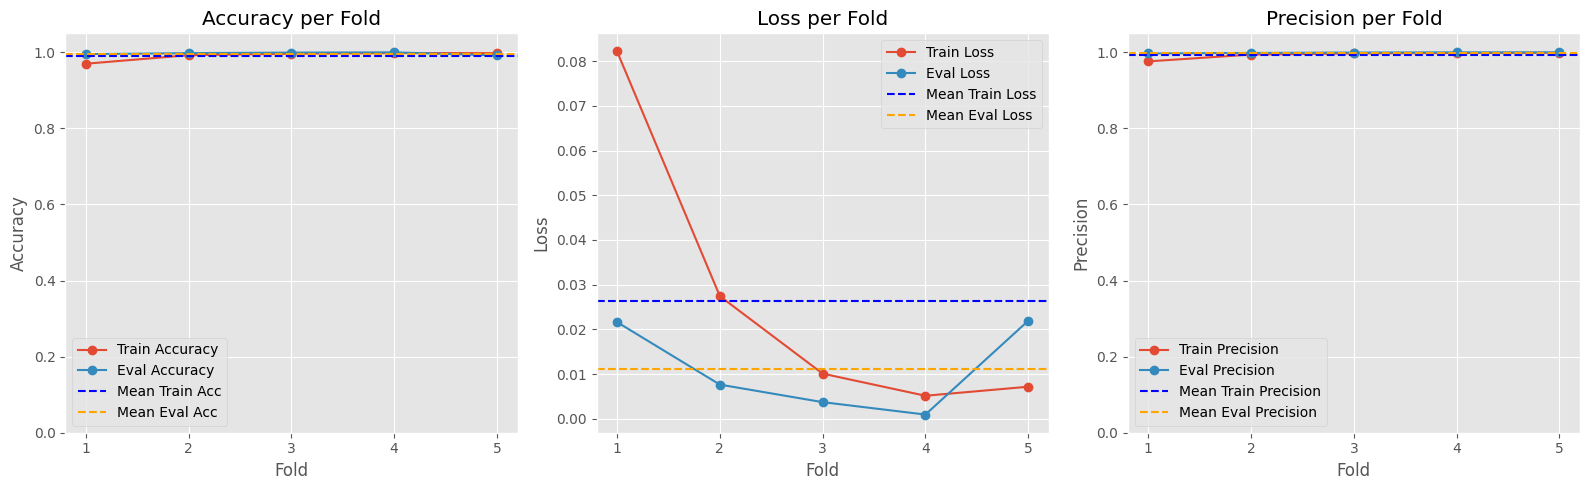

In [37]:
plot_training_metrics(class_model_performance_1)

#### With handling gradient Explode

In [38]:
class_model_performance_2 = classification_trainer_2.train(handle_gradient_explode=True)

,train_accuracy,eval_accuracy,train_loss,eval_loss,train_precision,eval_precision
fold,,,,,,
1,0.998201,1.0,0.004776,0.000350,0.998452,1.0
2,0.999775,1.0,0.000841,0.000171,0.999743,1.0
3,1.000000,1.0,0.000175,0.000075,1.000000,1.0
4,1.000000,1.0,0.000501,0.000044,1.000000,1.0
5,1.000000,1.0,0.000211,0.000037,1.000000,1.0
mean,0.999595,1.0,0.001301,0.000135,0.999639,1.0


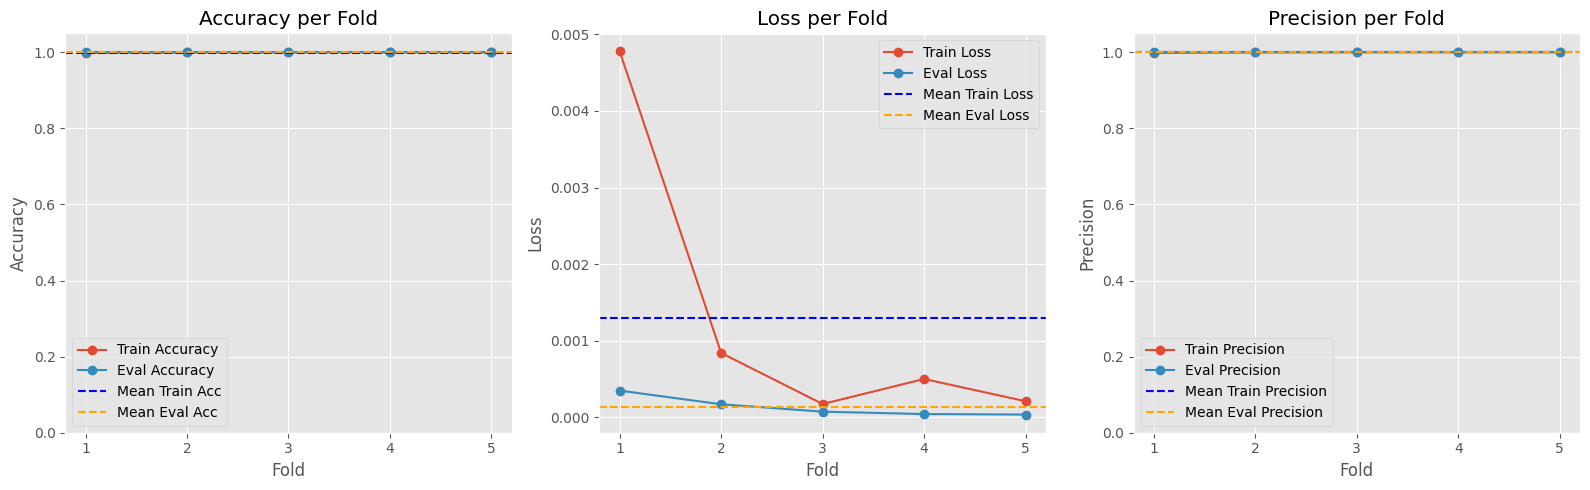

In [39]:
plot_training_metrics(class_model_performance_2)